<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/master/notebooks/unified_approach/2_Data_Treatment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 - Removing outliers, understanding the data, visualization of components for each dataset, common period for the different hospitals, data aggregation and transformation of categorical features into numerical ones.

---



---



# Loading libs and database

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m

df_url ="https://raw.githubusercontent.com/douglasmmachado/ExploratoryDataAnalysis/master/datasets/unified_approach/df_unified.csv"


df = pd.read_csv(df_url)



categorical_features = ['ID_REF', 'ID_SITE_RATTACHE', 'CODE_ATC', 'HOSPI_CODE_UCD']
date_features = ['DATE_MOUV', 'WEEK', 'MONTH', 'YEAR']
numerical_features = ['N_UFS', 'QUANTITY', 'N_ETB', 'POPULATION', 'P_MEDICAL', 'PN_MEDICAL', 'LIT_HC', 'LIT_HP', 'SEJ_MCO', 'SEJ_HAD', 'SEJ_PSY', 'SEJ_SSR']

df['DATE_MOUV'] = pd.to_datetime(df['DATE_MOUV'],
              format='%Y-%m-%d')  # Changed the type of date too

for column in categorical_features:
  df[column] = df[column].astype('string')

## 2.1 - Visualisation of data range and data composition

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75684 entries, 0 to 75683
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID_REF            75684 non-null  string        
 1   ID_SITE_RATTACHE  75684 non-null  string        
 2   CODE_ATC          75684 non-null  string        
 3   HOSPI_CODE_UCD    75684 non-null  string        
 4   DATE_MOUV         75684 non-null  datetime64[ns]
 5   N_UFS             75684 non-null  int64         
 6   QUANTITY          75684 non-null  float64       
 7   WEEK              75684 non-null  int64         
 8   MONTH             75684 non-null  int64         
 9   YEAR              75684 non-null  int64         
 10  N_ETB             75684 non-null  int64         
 11  POPULATION        75684 non-null  float64       
 12  P_MEDICAL         75684 non-null  int64         
 13  PN_MEDICAL        75684 non-null  int64         
 14  LIT_HC            7568

In [32]:
def visualize_distribution(df, features):
  '''
    Plot of distribution for the numerical features after removing the outliers
  '''

  fig, axes = plt.subplots(4, 3,sharex=False, figsize=(20,20))

  i = 0
  j = 0
  for column in features:
    sns.histplot(df[column], kde=True, stat="density", kde_kws=dict(cut=3),alpha=.4, edgecolor=(1, 1, 1, .4),ax=axes[i, j]).set(title='Distribution of: ' + str(column))
    if j == 2:
      i += 1
      j = 0
    else:
      j+=1

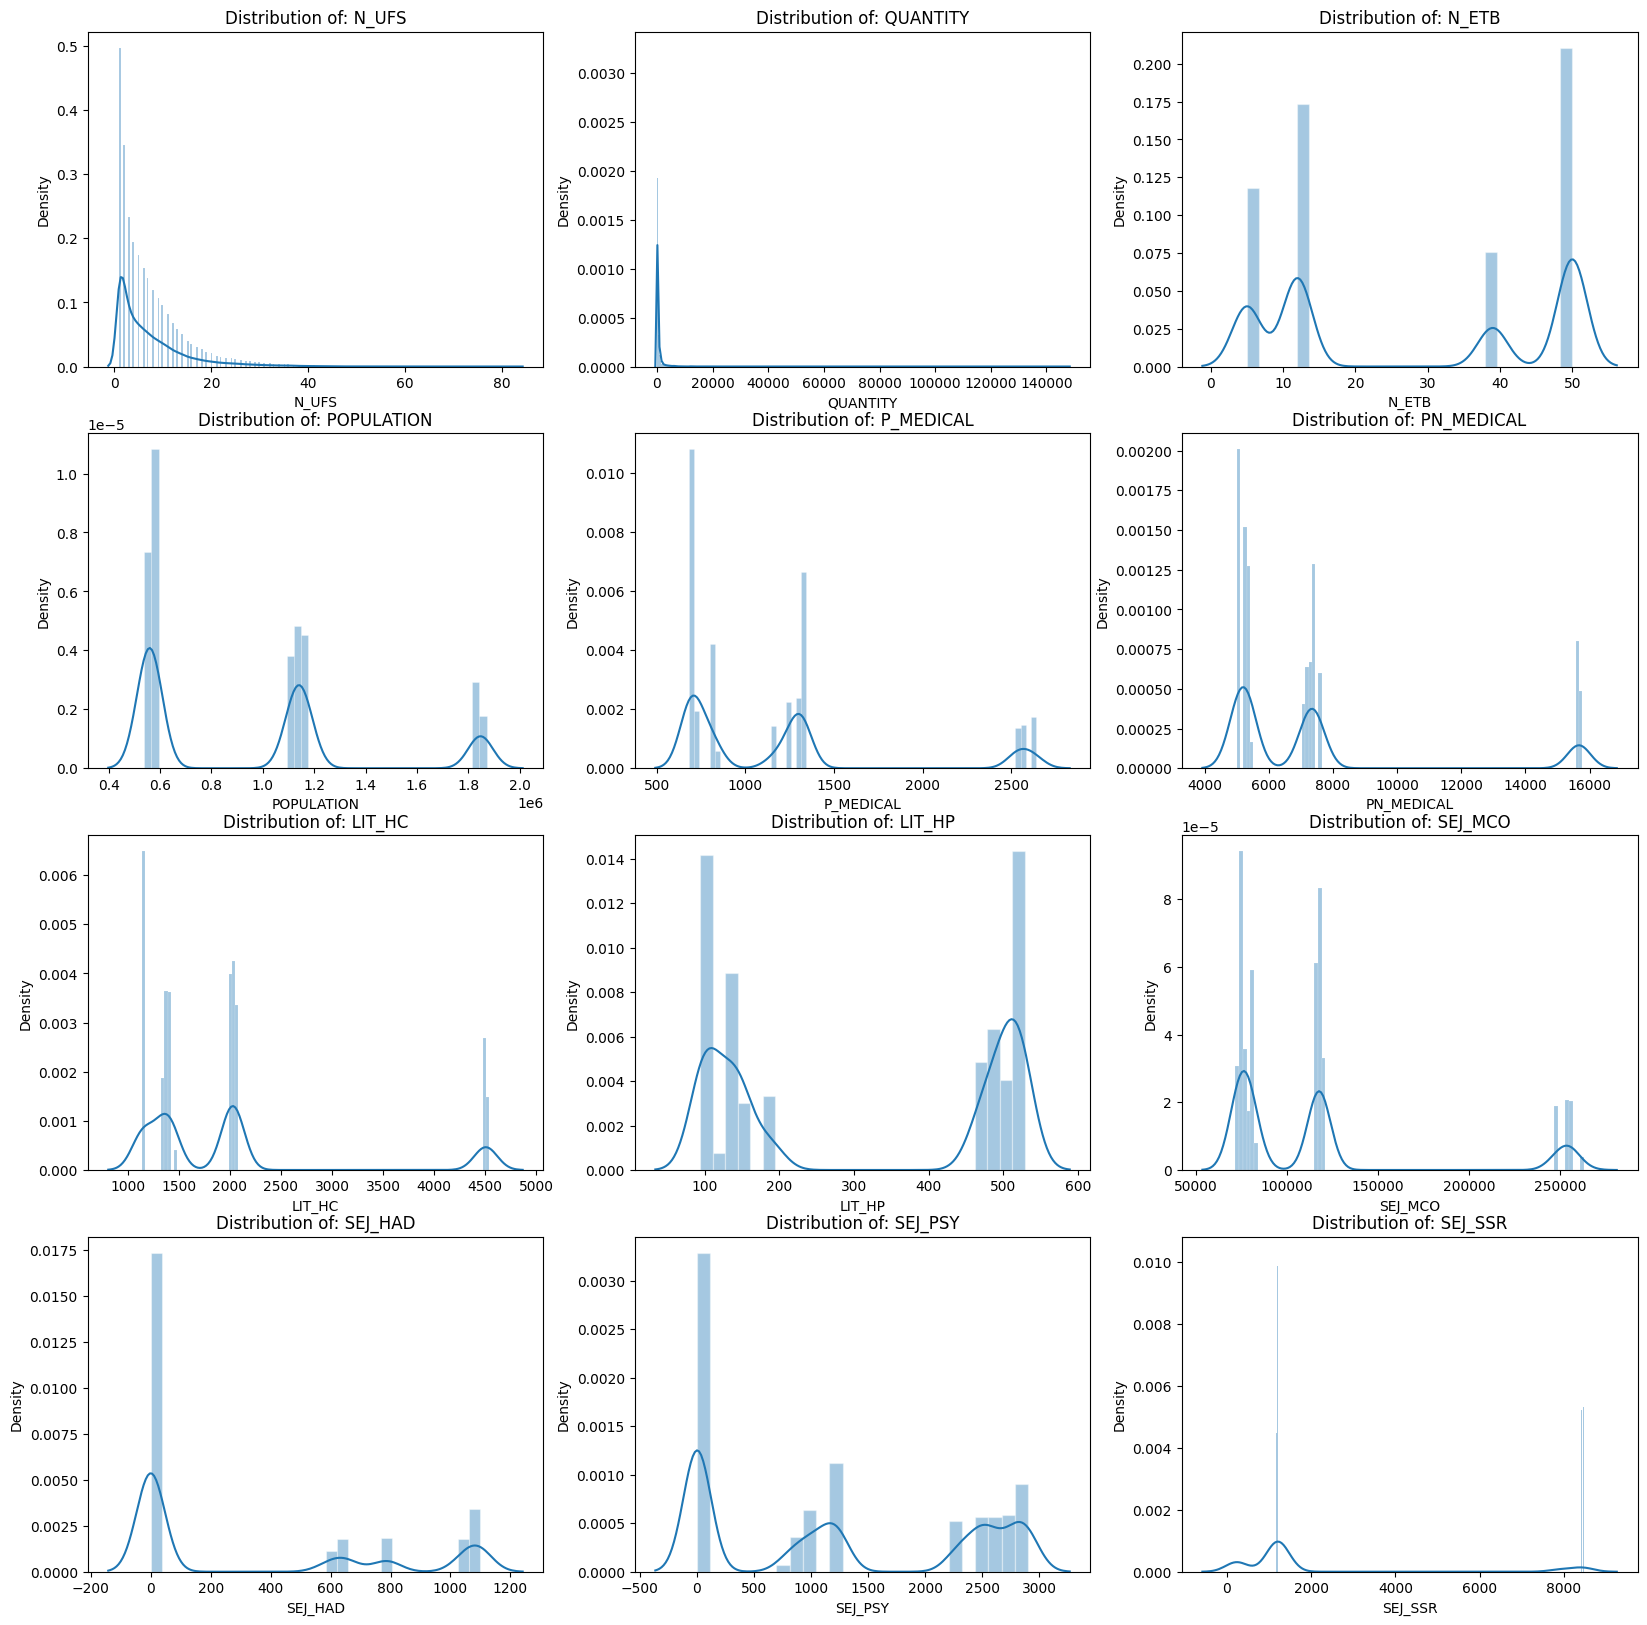

In [33]:
visualize_distribution(df, numerical_features)

## 2.2 - Removing outliers by hospital and by drug

In [34]:
def remove_outliers(df, columns, verbose=False):
    N_macro = df.shape[0]
    new_df = pd.DataFrame()  # Create an empty DataFrame to store the filtered values
    removed_outliers = 0  # Variable to keep track of the total number of removed outliers

    for col in columns:
        for ucd_code in df['HOSPI_CODE_UCD'].unique():
            # Filter the dataframe for the specific HOSPI_CODE_UCD
            df_subset = df[df['HOSPI_CODE_UCD'] == ucd_code]
            N = df_subset.shape[0]

            # Calculate the statistics for the column within the HOSPI_CODE_UCD subset
            q25, q75 = np.percentile(df_subset[col], [25, 75])
            iqr = q75 - q25
            lower, upper = q25 - (iqr * 1.5), q75 + (iqr * 1.5)

            # Remove outliers based on the cutoff values within the HOSPI_CODE_UCD subset
            df_filtered = df_subset[(df_subset[col] >= lower) & (df_subset[col] <= upper)]
            N_new = df_filtered.shape[0]
            delta = N - N_new

            # Update the new DataFrame with the filtered values
            new_df = pd.concat([new_df, df_filtered])

            if verbose:
                if delta > 0:
                    print(f'Column: {col}')
                    print(f'HOSPI_CODE_UCD: {ucd_code}')
                    print(f'Removed outliers: {delta}')
                    print(f'Removed percentage: {(100 * delta / N):.3}%')
                    print()

            removed_outliers += delta

    new_df.reset_index(drop=True, inplace=True)
    print('N_old:', N_macro)
    N_macro_new = new_df.shape[0]
    print('N_new:', N_macro_new)
    delta = N_macro - N_macro_new
    print(f'Total removed outliers: {(100 * delta / N_macro):.3}%')

    return new_df


In [35]:
print("-"*100)
df_wo_outliers = pd.concat([remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_1'], ["QUANTITY"], verbose = False),
                                remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_2'], ["QUANTITY"], verbose = False),
                                remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_3'], ["QUANTITY"], verbose = False),
                                remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_4'], ["QUANTITY"], verbose = False)])


----------------------------------------------------------------------------------------------------
N_old: 22725
N_new: 21715
Total removed outliers: 4.44%
N_old: 15439
N_new: 14953
Total removed outliers: 3.15%
N_old: 27591
N_new: 26801
Total removed outliers: 2.86%
N_old: 9929
N_new: 9638
Total removed outliers: 2.93%


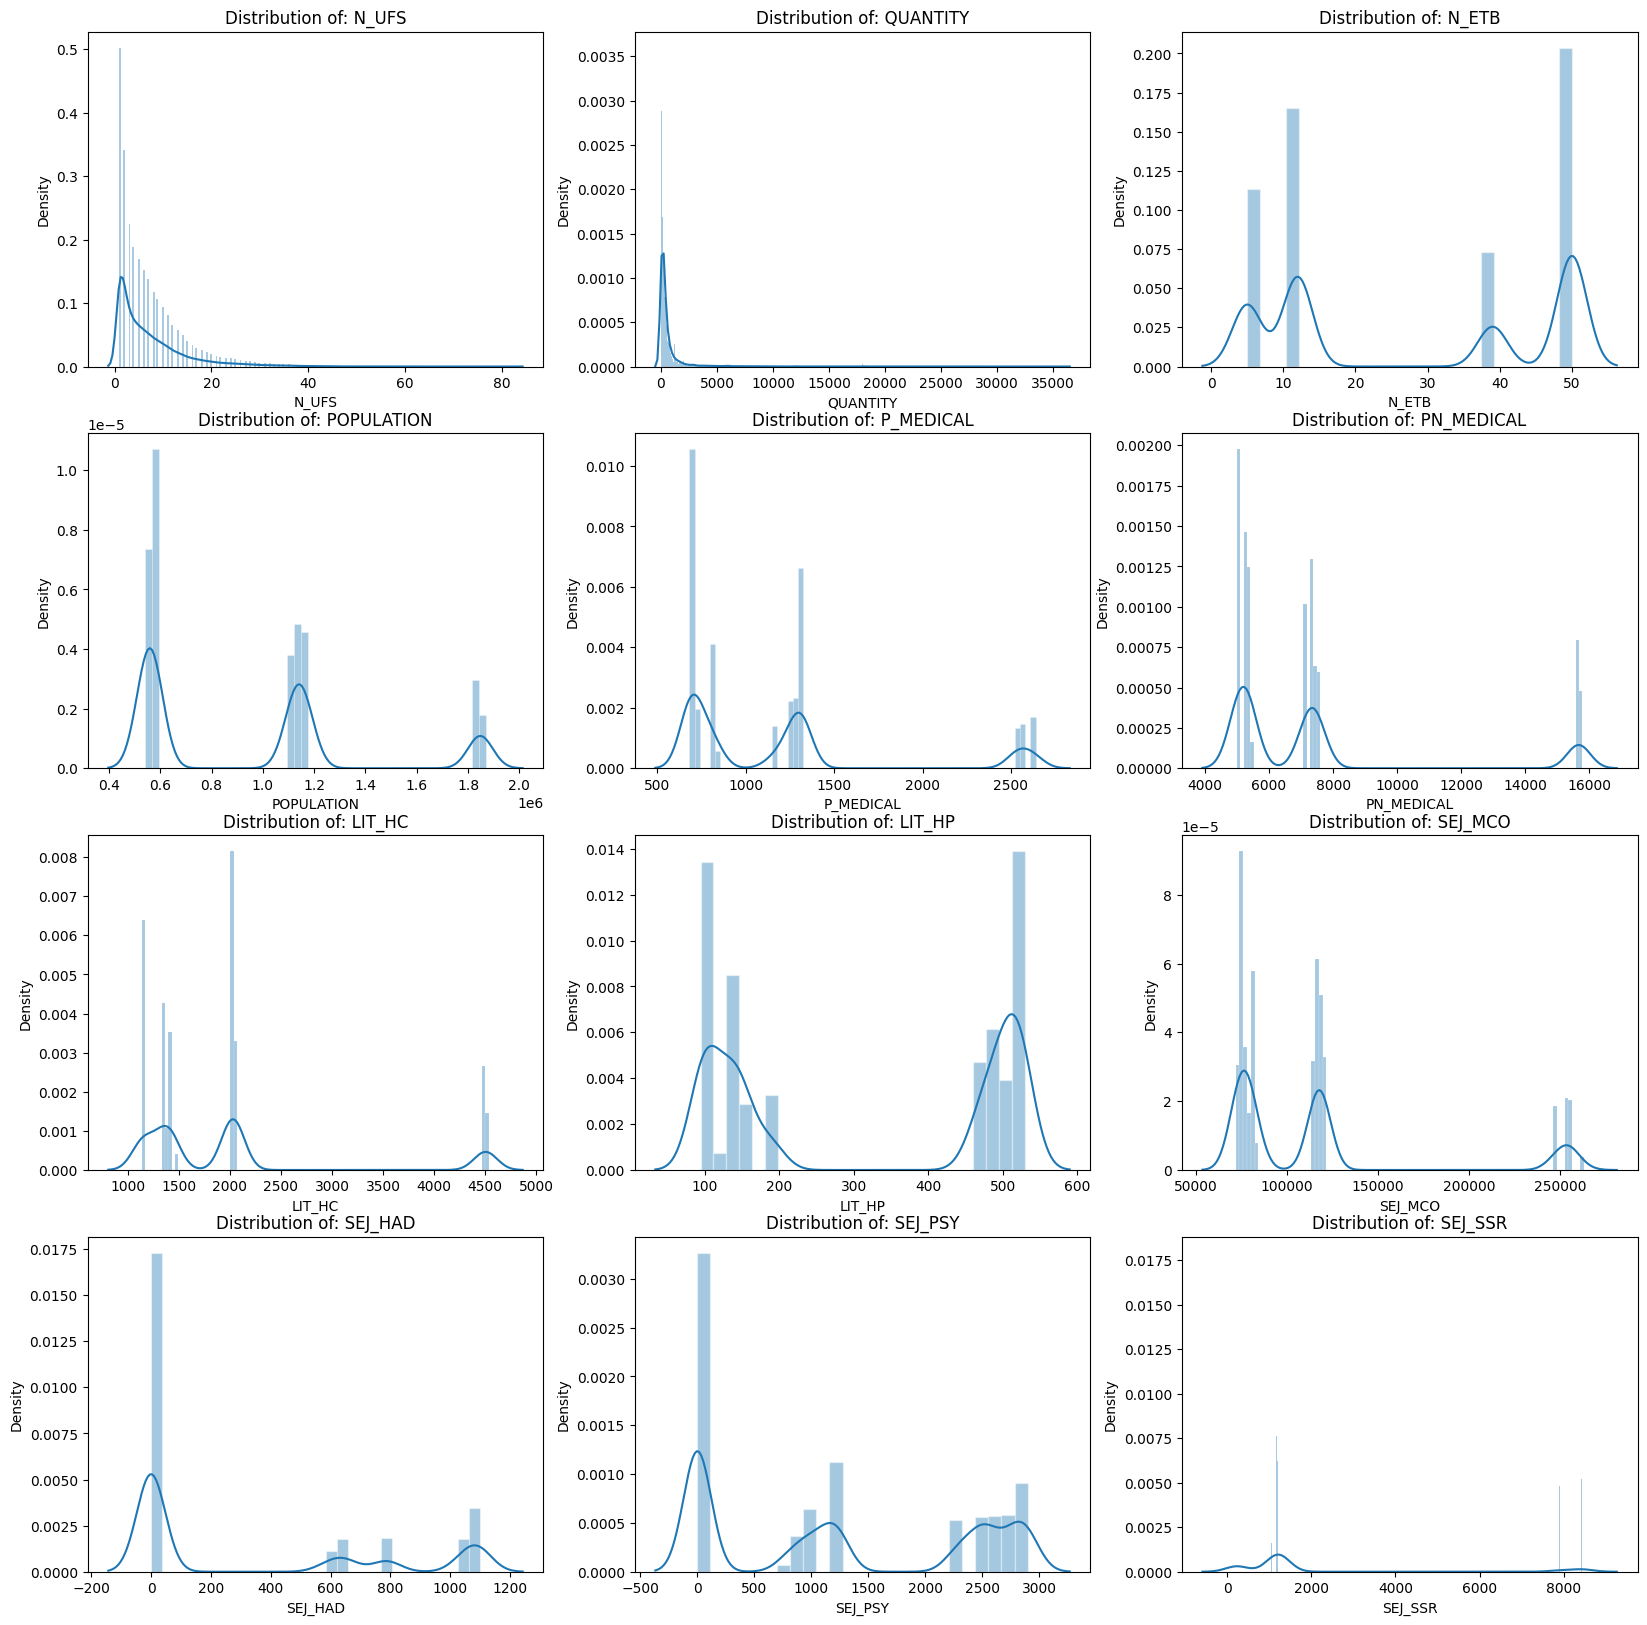

In [36]:
visualize_distribution(df_wo_outliers, numerical_features)

In [37]:
for column in categorical_features:
  df[column] = df[column].astype('string')

## 2.3 - Define common period for data usage

In [38]:
# Identifying a common period for the different timeseries
min_date_h1 = df[df['ID_SITE_RATTACHE'] == 'HOSPI_1']["DATE_MOUV"].min()
min_date_h2 = df[df['ID_SITE_RATTACHE'] == 'HOSPI_2']["DATE_MOUV"].min()
min_date_h3 = df[df['ID_SITE_RATTACHE'] == 'HOSPI_3']["DATE_MOUV"].min()
min_date_h4 = df[df['ID_SITE_RATTACHE'] == 'HOSPI_4']["DATE_MOUV"].min()

print(f'Min dates:' + f'\n H1: {min_date_h1}' + f'\n H2: {min_date_h2}' + f'\n H3: {min_date_h3}' + f'\n H4: {min_date_h4}')

max_date_h1 = df[df['ID_SITE_RATTACHE'] == 'HOSPI_1']["DATE_MOUV"].max()
max_date_h2 = df[df['ID_SITE_RATTACHE'] == 'HOSPI_2']["DATE_MOUV"].max()
max_date_h3 = df[df['ID_SITE_RATTACHE'] == 'HOSPI_3']["DATE_MOUV"].max()
max_date_h4 = df[df['ID_SITE_RATTACHE'] == 'HOSPI_4']["DATE_MOUV"].max()

print(f'\n Max dates:' + f'\n H1: {max_date_h1}' + f'\n H2: {max_date_h2}' + f'\n H3: {max_date_h3}' + f'\n H4: {max_date_h4}')

init = max(min_date_h1, min_date_h2, min_date_h3, min_date_h4)
ending = min(max_date_h1, max_date_h2, max_date_h3, max_date_h4)

print('\n')
print(f'Begin date: {init}')
print(f'End date: {ending}')

Min dates:
 H1: 2013-06-18 00:00:00
 H2: 2017-03-30 00:00:00
 H3: 2014-05-20 00:00:00
 H4: 2016-01-01 00:00:00

 Max dates:
 H1: 2019-12-30 00:00:00
 H2: 2019-12-30 00:00:00
 H3: 2019-12-30 00:00:00
 H4: 2019-03-05 00:00:00


Begin date: 2017-03-30 00:00:00
End date: 2019-03-05 00:00:00


In [59]:
common_period = pd.date_range(start=pd.Timestamp(year=init.year, month=init.month, day=1), end=pd.Timestamp(year=ending.year, month=ending.month, day=31))

df_cp = df_wo_outliers[(df_wo_outliers["DATE_MOUV"] >= init) & (df_wo_outliers["DATE_MOUV"] <= ending)].copy()
df_cp = df_cp.drop('ID_SITE_RATTACHE',axis=1).copy()

categorical_features_set = set(categorical_features)
categorical_features_set.remove('ID_SITE_RATTACHE')

## 2.4 - Fill gaps in data for eache medicine and for each hospital

In [45]:
def fill_gap_timeseries(df_cp, common_period,hospital='', visu=False):
    for medicine in df.HOSPI_CODE_UCD.unique():
        id_ref = df_cp[df_cp["HOSPI_CODE_UCD"] == medicine]["ID_REF"].values[0]
        cod_atc = df_cp[df_cp["HOSPI_CODE_UCD"] == medicine]["CODE_ATC"].values[0]

        data = {
            'DATE_MOUV': list(common_period),
            'HOSPI_CODE_UCD': [medicine] * len(common_period),
            'ID_REF': [id_ref] * len(common_period),
            'CODE_ATC': [cod_atc] * len(common_period),
        }

        df_medicine = pd.DataFrame(data)

        df_medicine_resampled = pd.merge(df_medicine, df_cp.astype({'DATE_MOUV': 'datetime64[ns]'}),
                                         on=['DATE_MOUV', 'HOSPI_CODE_UCD', 'ID_REF', 'CODE_ATC'], how='left')

        df_medicine_resampled = pd.merge(df_medicine, df_cp, on=['DATE_MOUV', 'HOSPI_CODE_UCD', 'ID_REF', 'CODE_ATC'], how='left')
        df_medicine_resampled['N_ETB'] = df_medicine_resampled['N_ETB'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['N_UFS'] = df_medicine_resampled['N_UFS'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['POPULATION'] = df_medicine_resampled['POPULATION'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['P_MEDICAL'] = df_medicine_resampled['P_MEDICAL'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['PN_MEDICAL'] = df_medicine_resampled['PN_MEDICAL'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['LIT_HC'] = df_medicine_resampled['LIT_HC'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['LIT_HP'] = df_medicine_resampled['LIT_HP'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['SEJ_MCO'] = df_medicine_resampled['SEJ_MCO'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['SEJ_HAD'] = df_medicine_resampled['SEJ_HAD'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['SEJ_PSY'] = df_medicine_resampled['SEJ_PSY'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['SEJ_SSR'] = df_medicine_resampled['SEJ_SSR'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['SEJ_SLD'] = df_medicine_resampled['SEJ_SLD'].fillna(method='ffill').fillna(method='bfill')
        df_medicine_resampled['QUANTITY'] = df_medicine_resampled['QUANTITY'].fillna(0)

        df_cp = df_cp[df_cp["HOSPI_CODE_UCD"] != medicine]
        df_cp = pd.concat([df_cp, df_medicine_resampled], ignore_index=True)

    df_cp = df_cp.sort_values(by=['DATE_MOUV']).reset_index(drop=True)
    df_cp["WEEK"] = df_cp["DATE_MOUV"].dt.isocalendar().week
    df_cp["YEAR"] = df_cp["DATE_MOUV"].dt.year
    df_cp["MONTH"] = df_cp["DATE_MOUV"].dt.month

    x = common_period

    if visu:
        fig, axs = plt.subplots(7, 3, figsize=(25, 25))

        for i, medicine in enumerate(df.HOSPI_CODE_UCD.unique()):
            row = i // 3  # Calculate the row index
            col = i % 3   # Calculate the column index

            ax = axs[row, col]  # Get the corresponding subplot

            y = df_cp[df_cp["HOSPI_CODE_UCD"] == medicine]["QUANTITY"]
            ax.scatter(x, y)
            ax.set_title(f'Consumption quantity of medicine: {medicine} per day')
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
            ax.grid()

        plt.tight_layout()
        plt.show()

    return df_cp


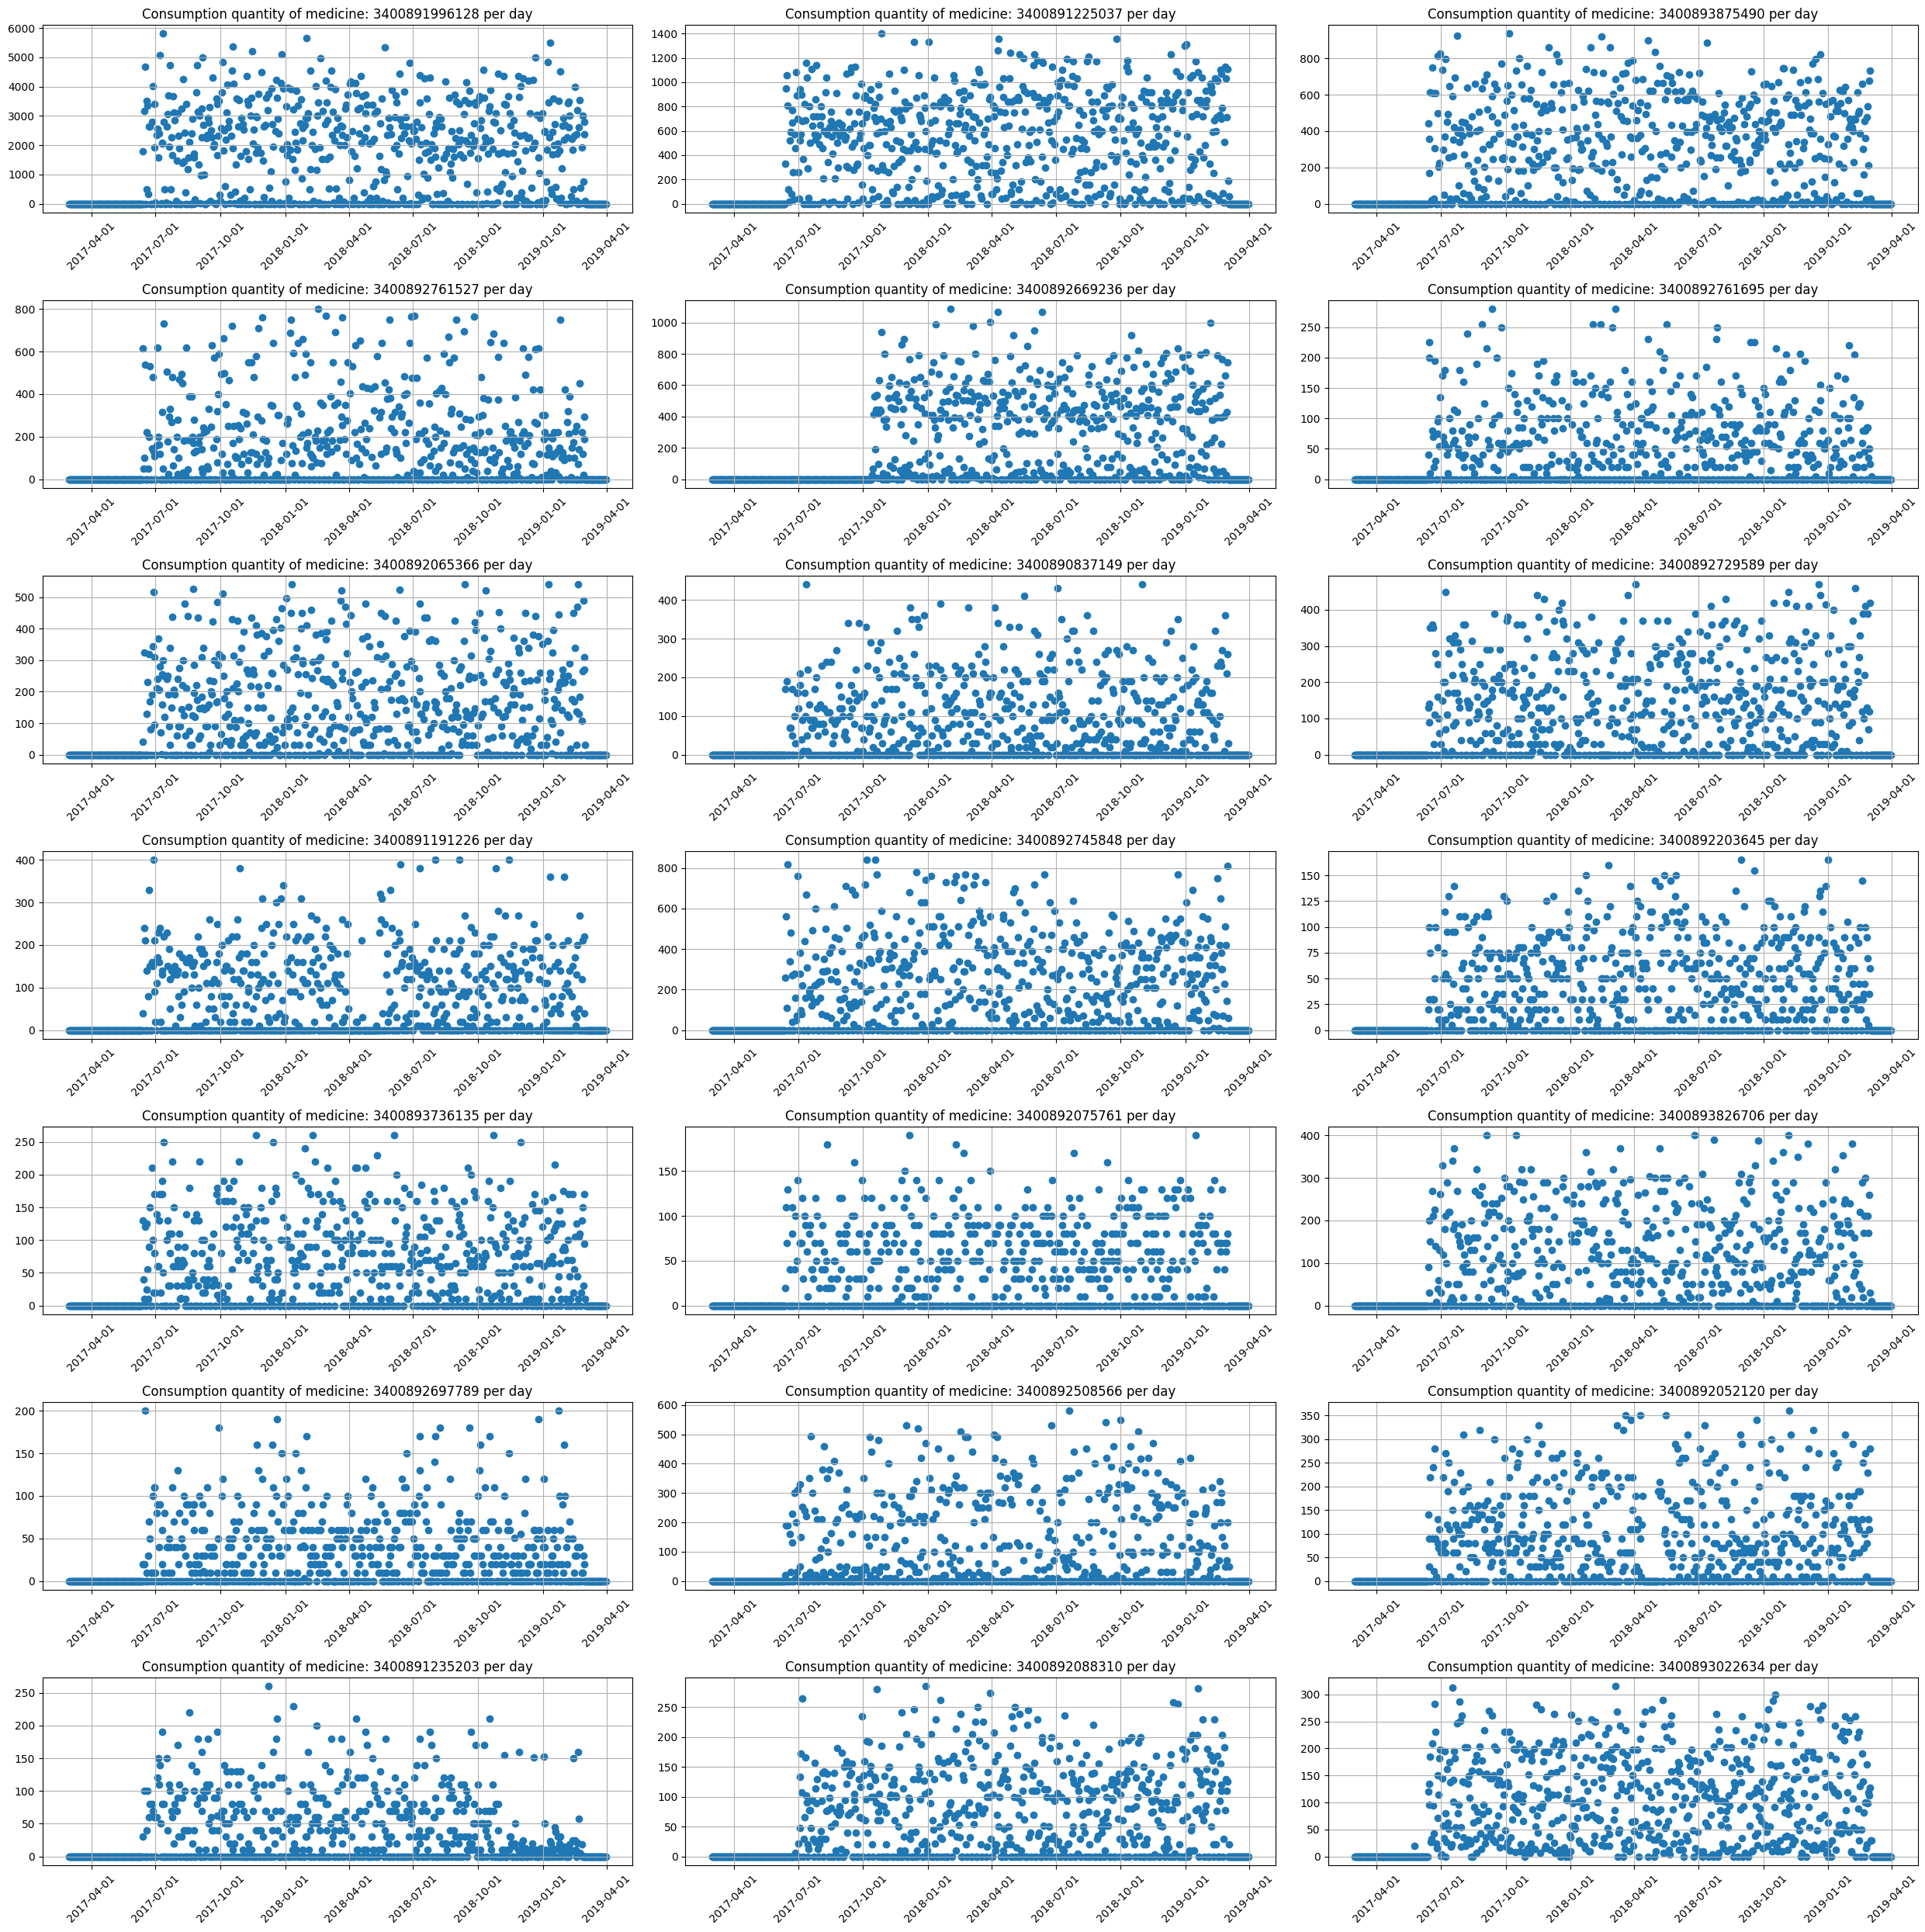

In [46]:
df_cp_filled = fill_gap_timeseries(df_cp.copy(), common_period, visu= True)

## 2.5 - Aggregate data by drug, hospital, year and month

In [61]:
def aggregate_dataframe(df, columns_wo_quantity):


    for column in categorical_features_set:
      df[column] = df[column].astype('string')

    df['DATE'] = df['DATE_MOUV'].dt.strftime('%Y-%m')
    df.drop('DATE_MOUV', axis=1, inplace=True)

    df = df.groupby(["HOSPI_CODE_UCD", "YEAR", "MONTH"], as_index=False).agg({
        'QUANTITY': np.sum,
        'CODE_ATC': 'first',
        'N_UFS': np.median,
        'DATE':'first',
        'WEEK': 'first',
        'N_ETB': np.median,
        'POPULATION': np.median,
        'P_MEDICAL': np.median,
        'PN_MEDICAL': np.median,
        'LIT_HC': np.median,
        'LIT_HP': np.median,
        'SEJ_MCO': np.median,
        'SEJ_HAD': np.median,
        'SEJ_PSY': np.median,
        'SEJ_SSR': np.median,
        'SEJ_SLD': np.median
    })

    for column in columns_wo_quantity:
      for date in df['DATE'].unique():
        values = df[(df['DATE'] == date)][column].values
        median = m.ceil(np.median(values))
        df.loc[(df['DATE'] == date), column] = median


    df.sort_values(by=['DATE'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [62]:
# Grouping the different datasets divided by hospital
columns_wo_quantity = ['N_ETB', 'POPULATION', 'P_MEDICAL', 'PN_MEDICAL', 'LIT_HC', 'LIT_HP', 'SEJ_MCO', 'SEJ_HAD', 'SEJ_PSY', 'SEJ_SSR']

df_aggregated = aggregate_dataframe(df_cp_filled.copy(), columns_wo_quantity)

## 2.6 - Visualize period and replace outliers with median

In [68]:
def plot_columns_bfaf(df_before, df_after, column, date_before = 'DATE_MOUV', date_after = 'DATE'):

    df_hospi_before = df_before[(df_before[date_before] >= init) & (df_before[date_before] <= ending)]
    df_hospi_before = df_hospi_before.sort_values(by=[date_before]).reset_index(drop=True)

    if column == 'QUANTITY':
      for medicine in df_before.HOSPI_CODE_UCD.unique():

        # Plot 1
        x = df_hospi_before[df_hospi_before['HOSPI_CODE_UCD'] == medicine][date_before]

        y = df_hospi_before[df_hospi_before['HOSPI_CODE_UCD'] == medicine][column].values

        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        axs[0].scatter(x, y)
        axs[0].set_xlabel(date_before)
        axs[0].set_ylabel(column)
        axs[0].set_title(f'{column} Before aggregation' + f' medicine: {medicine}')
        axs[0].grid(True)
        axs[0].set_xticks(axs[0].get_xticks())
        axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)

        # Plot 2
        x = df_after[df_after['HOSPI_CODE_UCD'] == medicine][date_after]
        y = df_after[df_after['HOSPI_CODE_UCD'] == medicine][column].values
        axs[1].scatter(x, y)
        axs[1].set_xlabel(date_after)
        axs[1].set_ylabel(column)
        axs[1].set_title(f'{column} After aggregation' + f' medicine: {medicine}')
        axs[1].grid(True)
        axs[1].set_xticks(axs[1].get_xticks())
        axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)

        plt.tight_layout()
        plt.show()
        print()

    else:
      fig, axs = plt.subplots(1, 2, figsize=(12, 4))
      x = df_hospi_before[date_before]

      y = df_hospi_before[column]

      axs[0].scatter(x, y)
      axs[0].set_xlabel(date_before)
      axs[0].set_ylabel(column)
      axs[0].set_title(f'{column} Before aggregation')
      axs[0].grid(True)
      axs[0].set_xticks(axs[0].get_xticks())
      axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)

      # Plot 2
      x = df_after[date_after]
      y = df_after[column].values
      axs[1].scatter(x, y)
      axs[1].set_xlabel(date_after)
      axs[1].set_ylabel(column)
      axs[1].set_title(f'{column} After aggregation')
      axs[1].grid(True)
      axs[1].set_xticks(axs[1].get_xticks())
      axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)

      plt.tight_layout()
      plt.show()
      print()

In [66]:
def replace_numerical_outliers(df, column_name):
  for medicine in df.HOSPI_CODE_UCD.unique():
      subset = df[df['HOSPI_CODE_UCD'] == medicine]
      q1 = subset[column_name].quantile(0.25)
      q3 = subset[column_name].quantile(0.75)
      iqr = q3 - q1
      lower_bound = q1 - 1.5 * iqr

      upper_bound = q3 + 1.5 * iqr
      outliers = (subset[column_name] < lower_bound) | (subset[column_name] > upper_bound)
      subset.loc[outliers, column_name] = subset[column_name].median()
      df.update(subset)

In [67]:
df_resampled = df_aggregated.copy()

replace_numerical_outliers(df_resampled, 'QUANTITY')

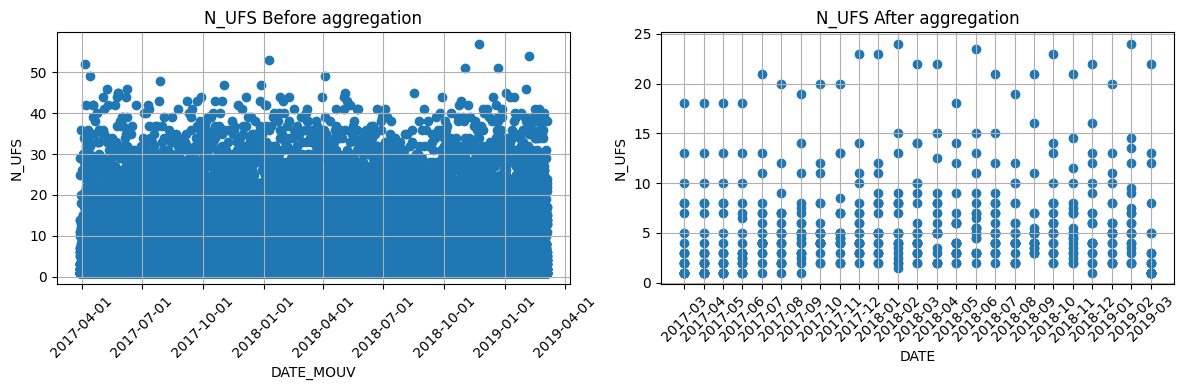

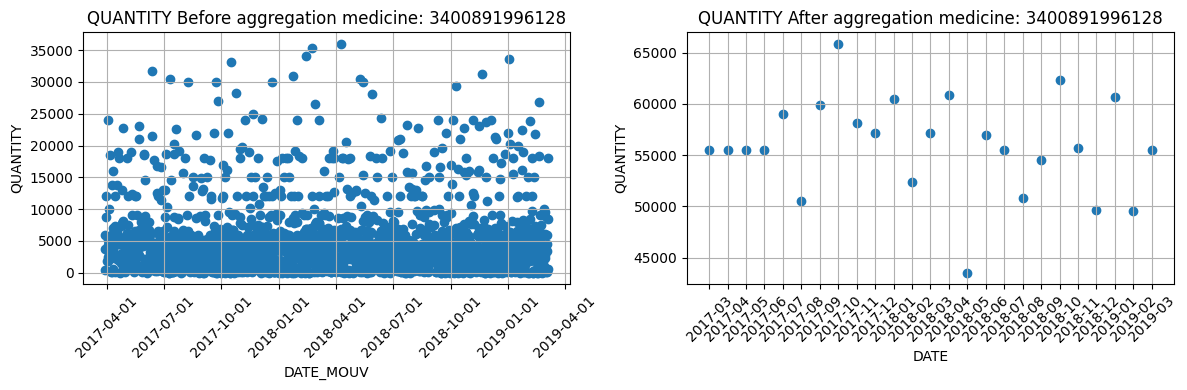

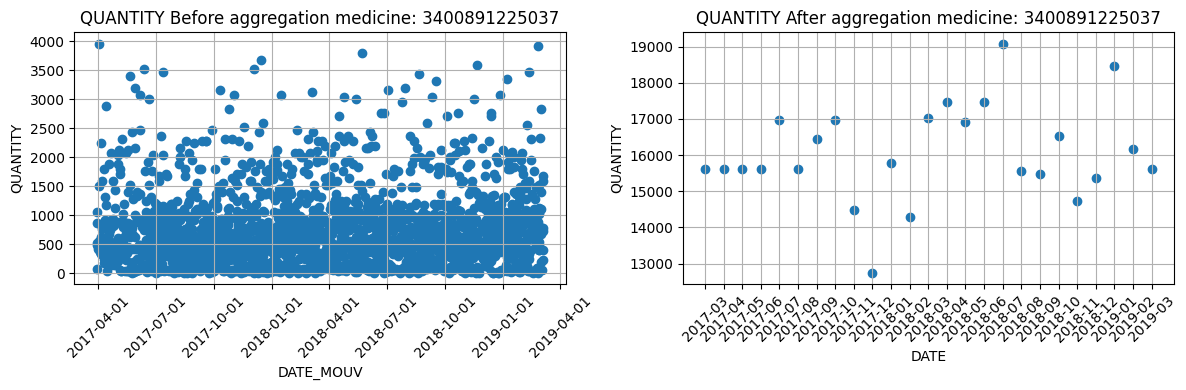

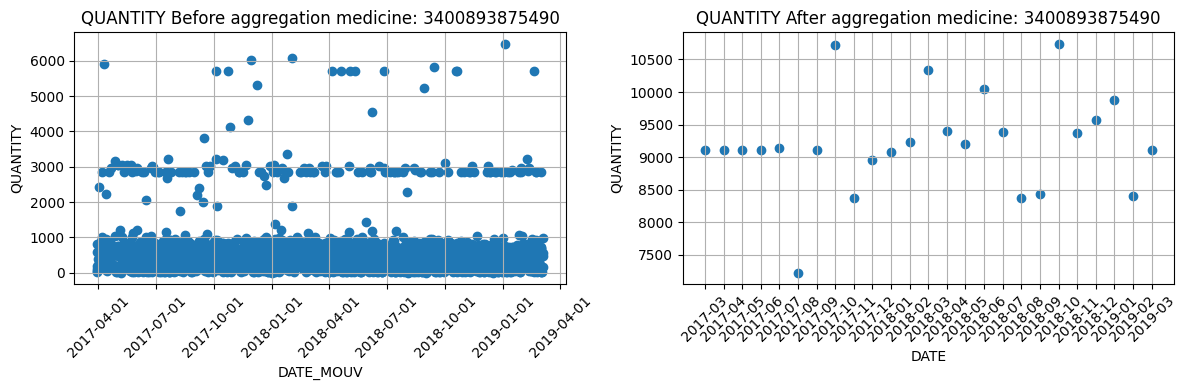

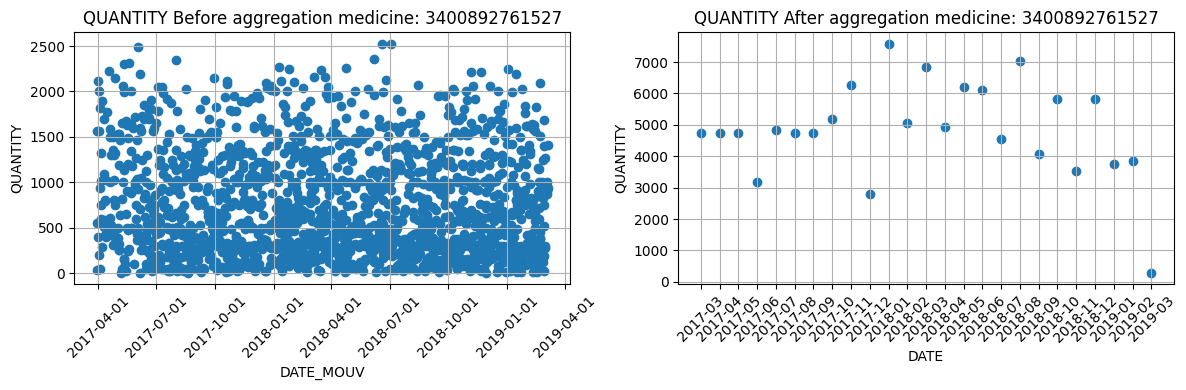

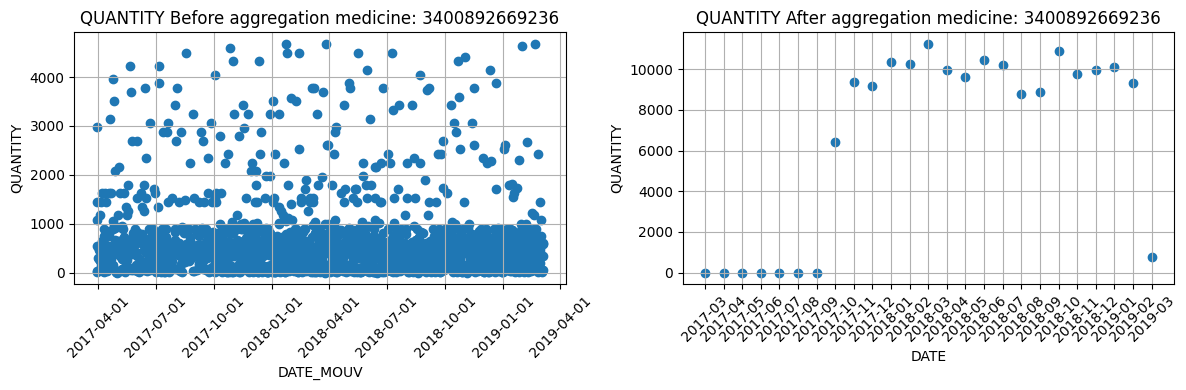

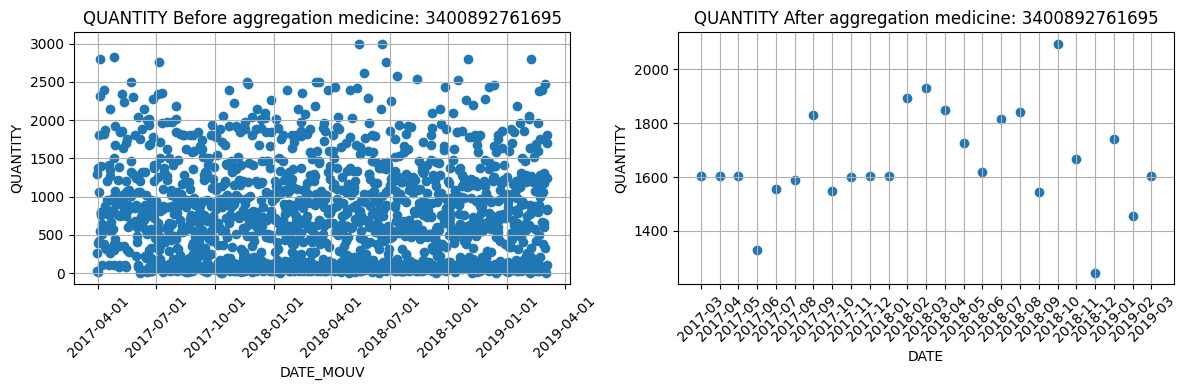

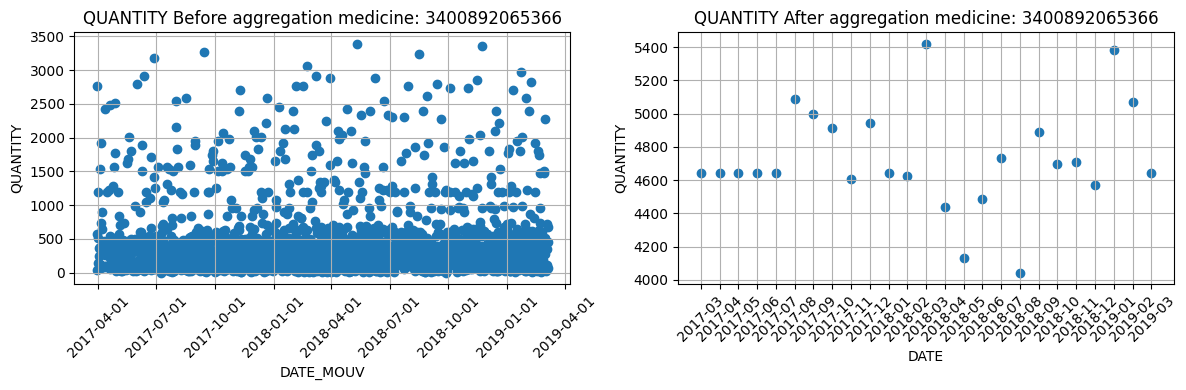

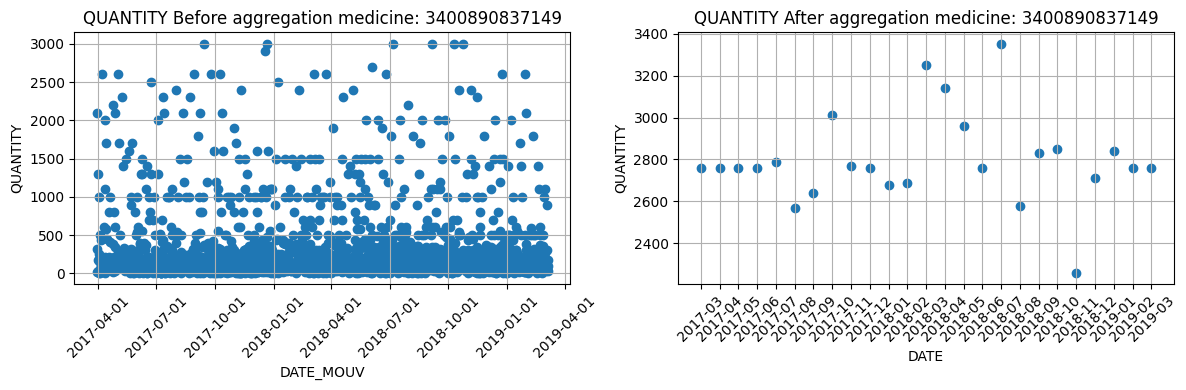

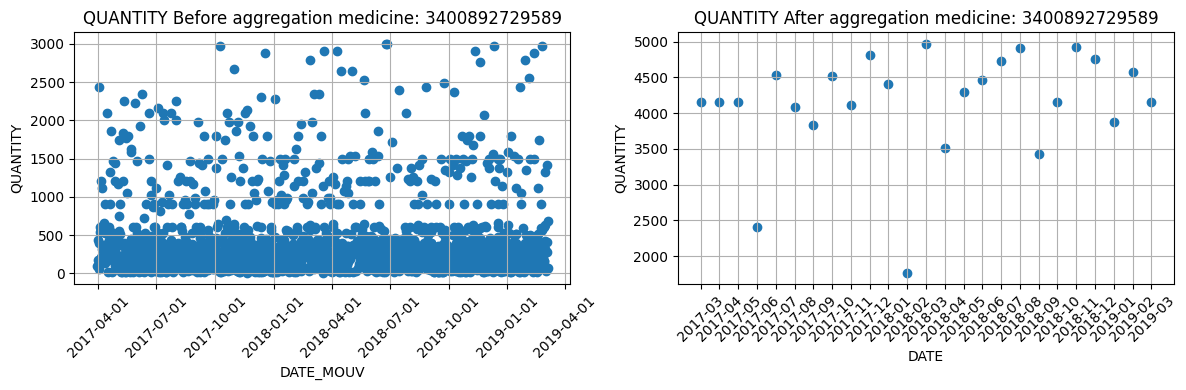

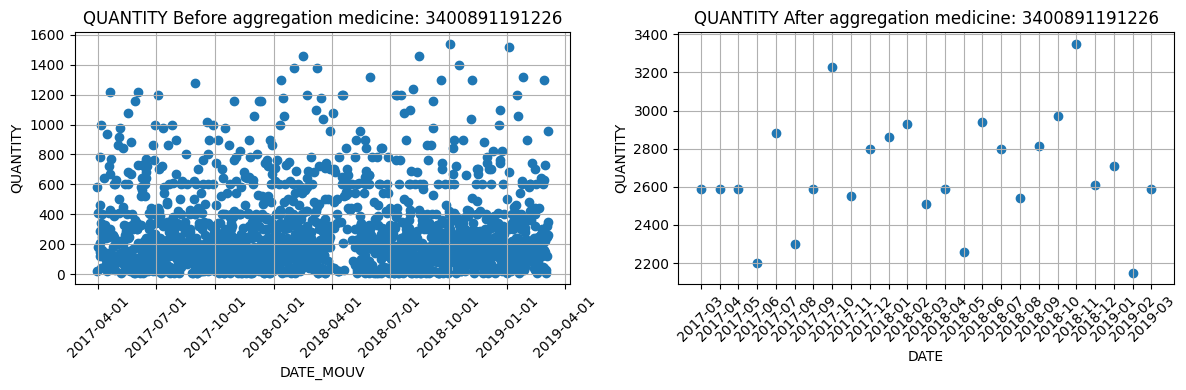

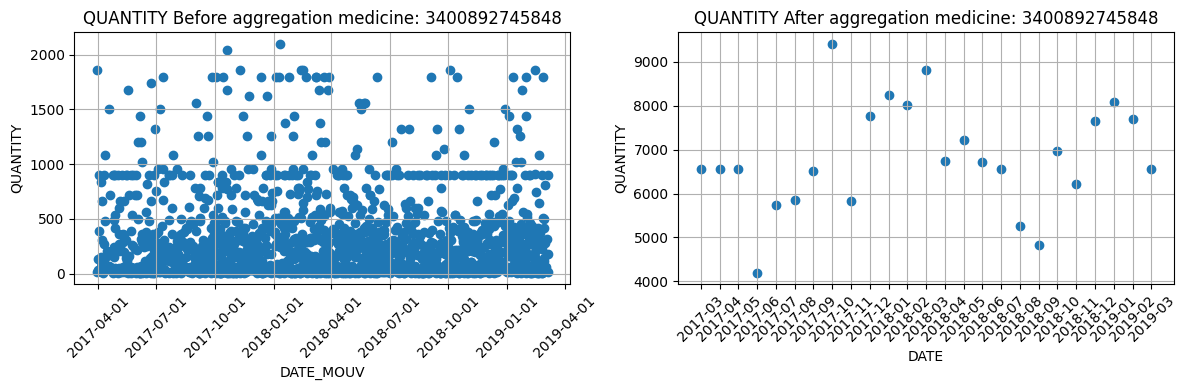

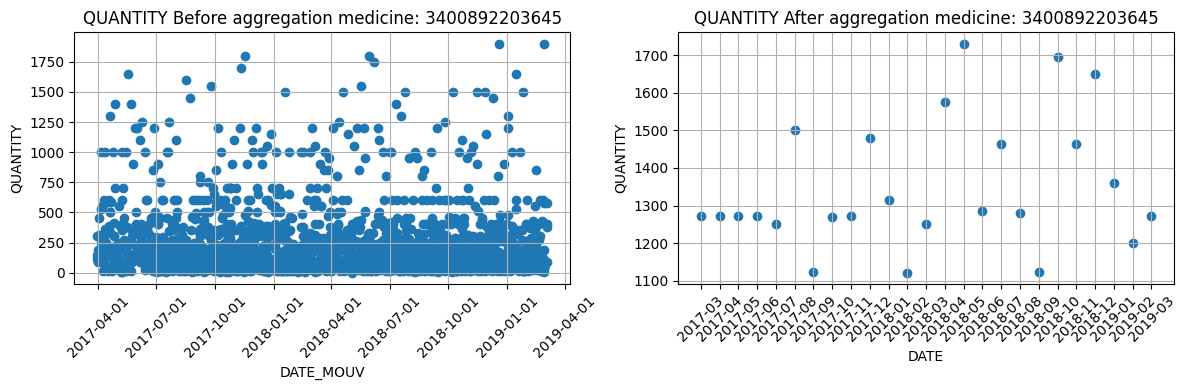

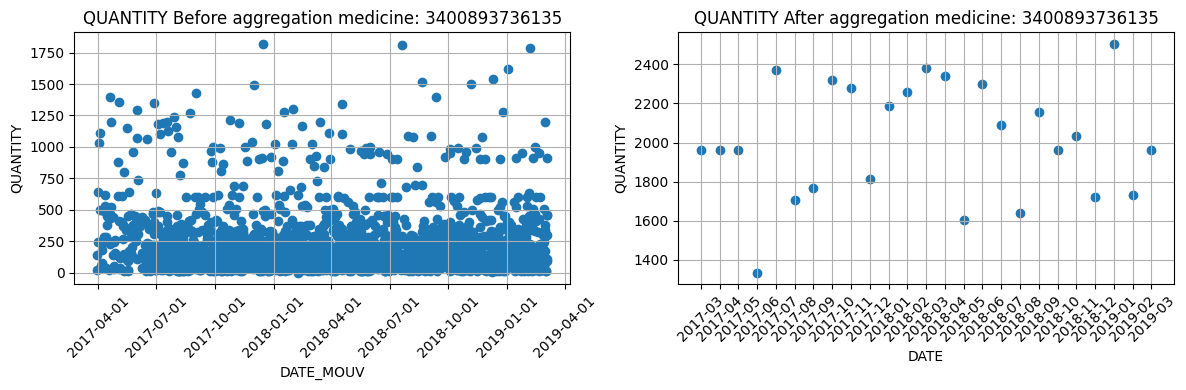

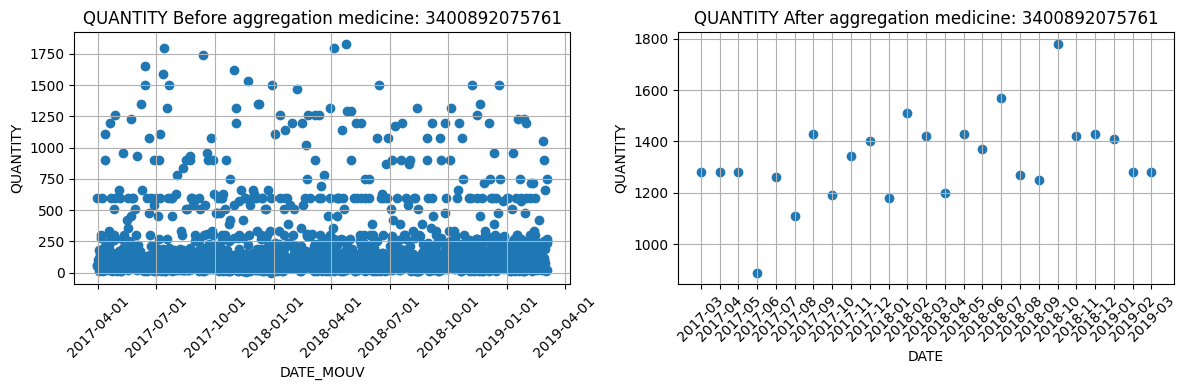

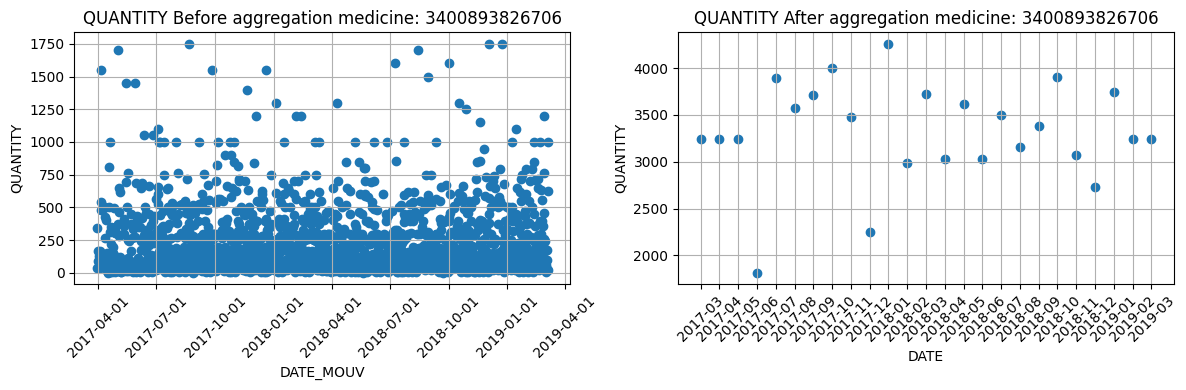

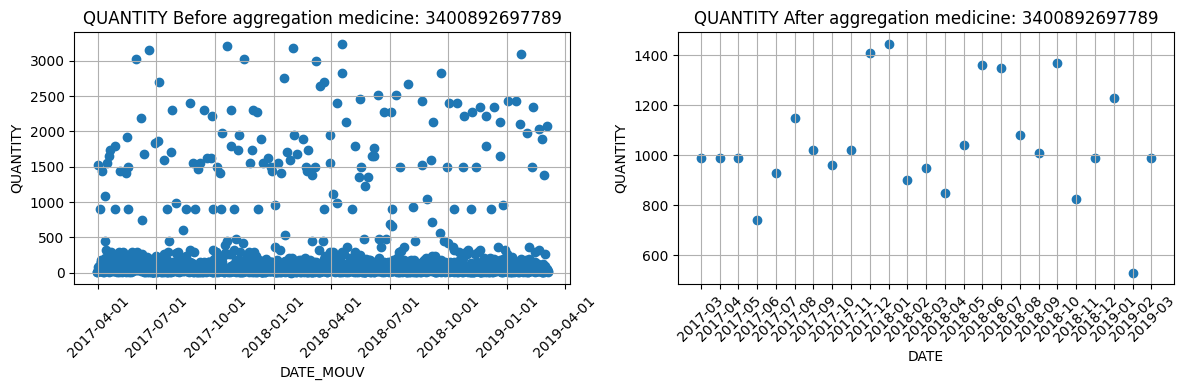

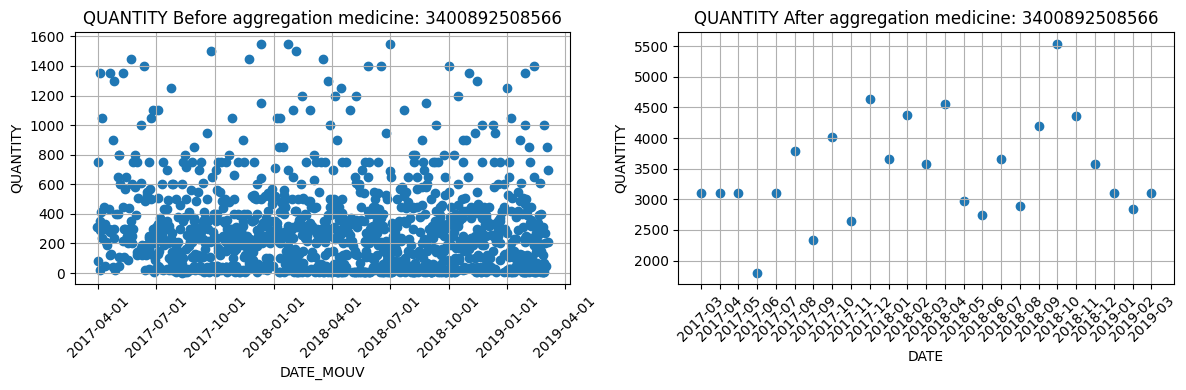

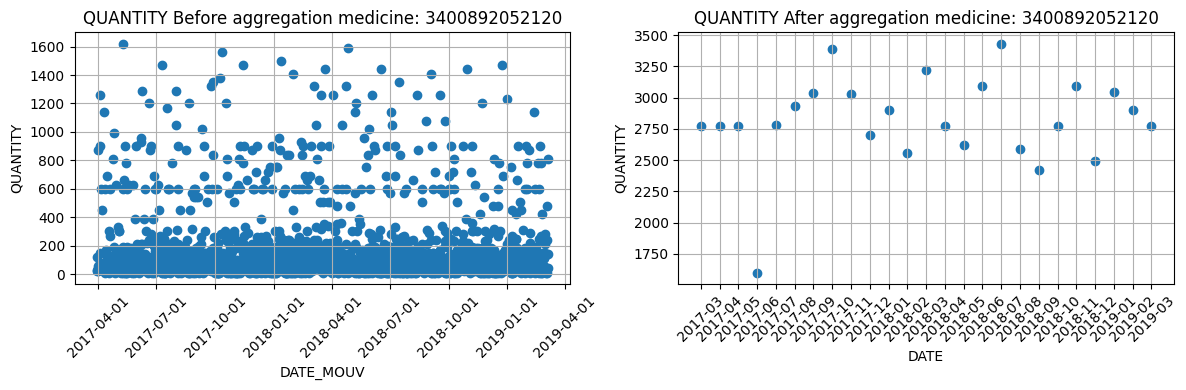

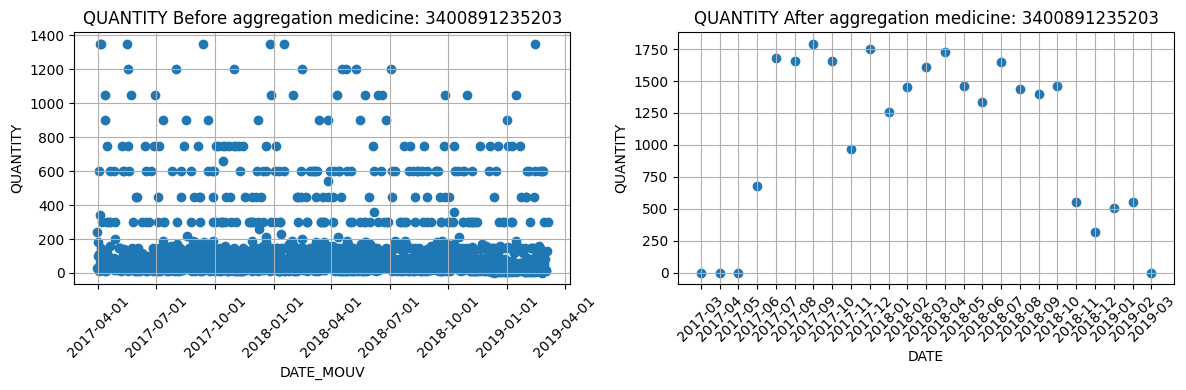

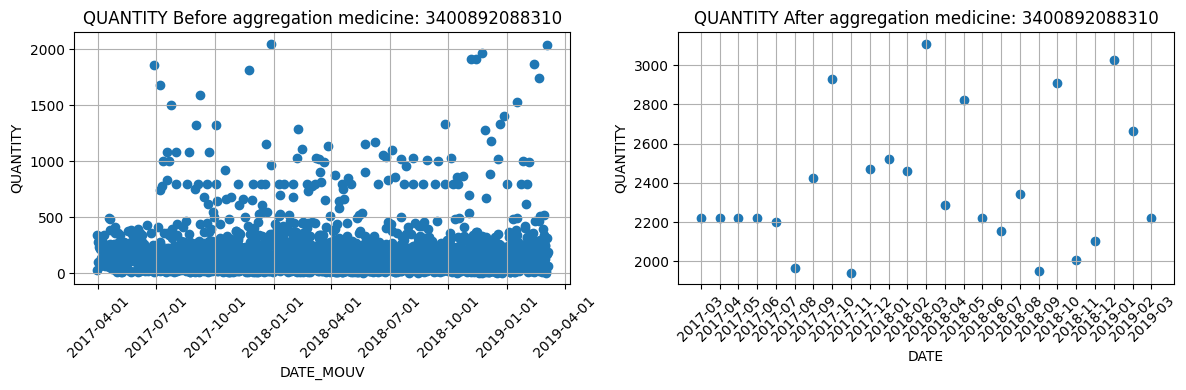

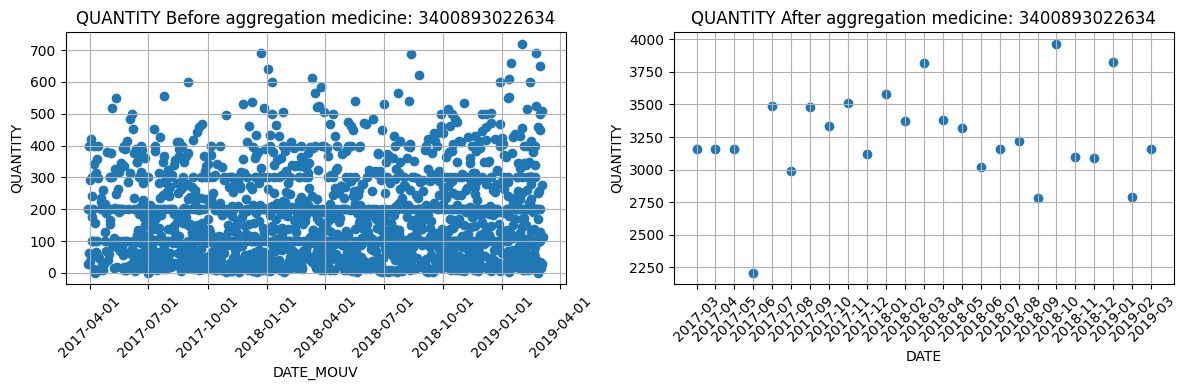

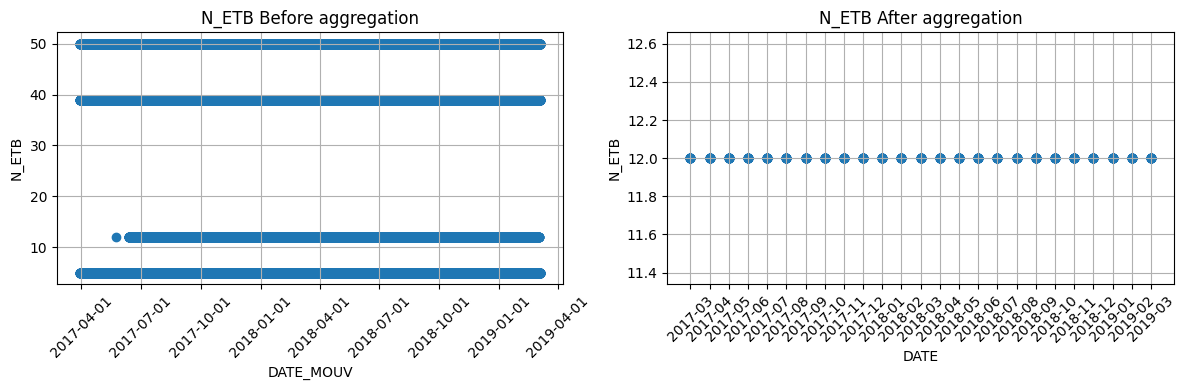

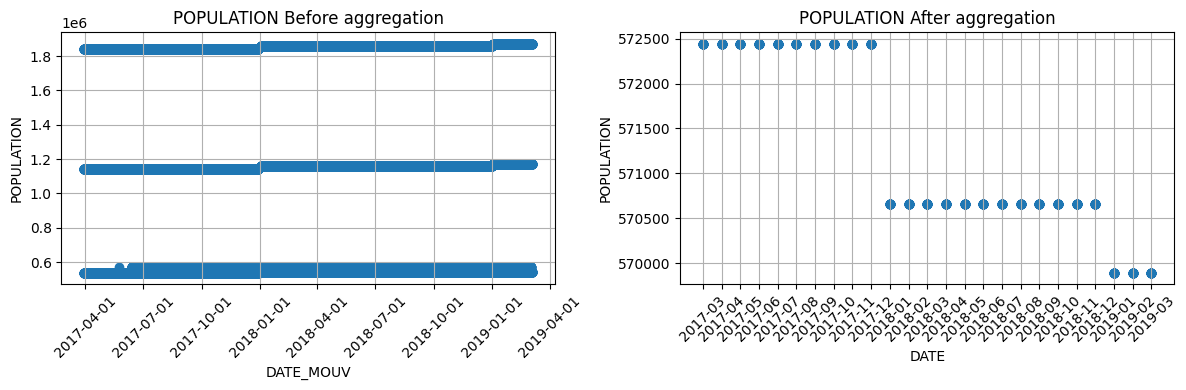

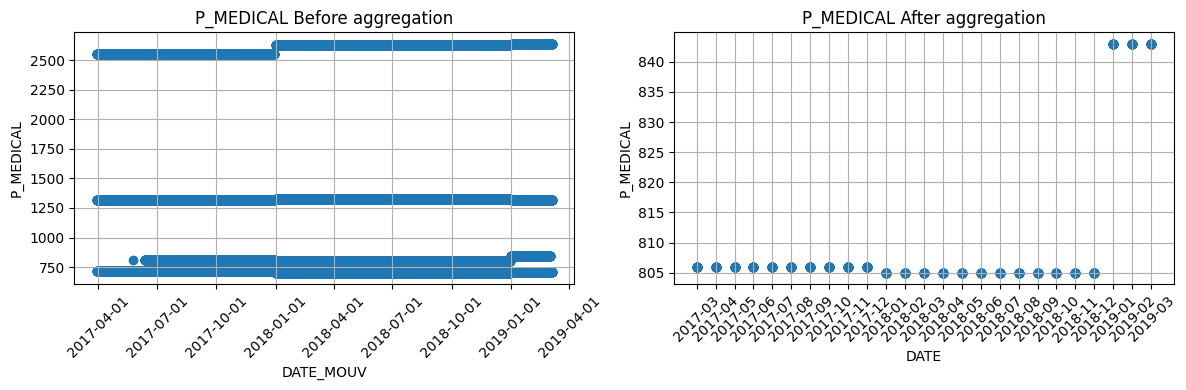

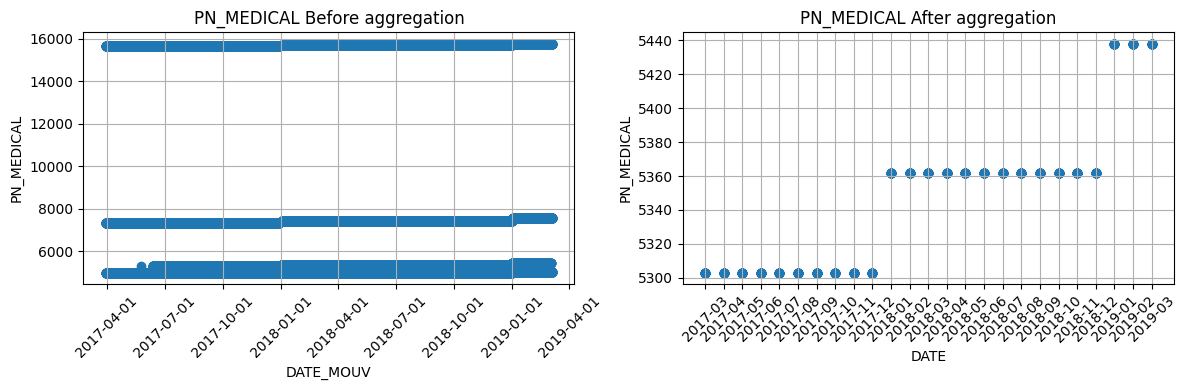

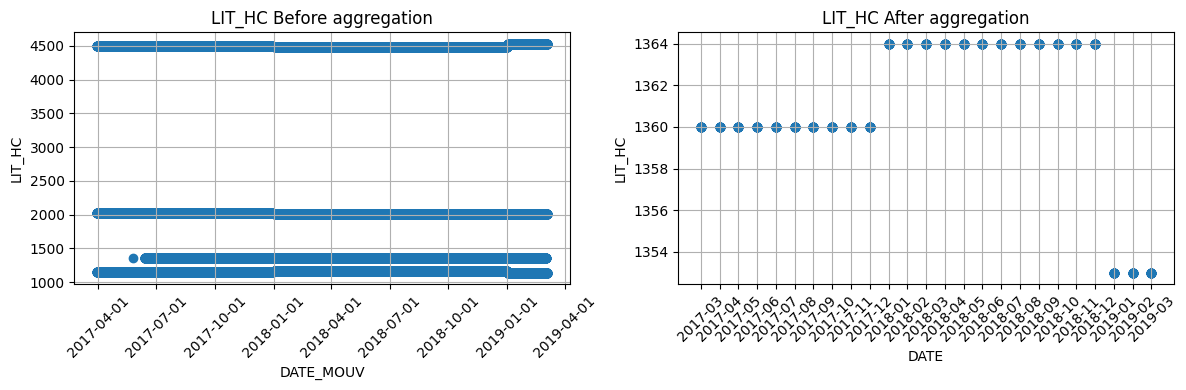

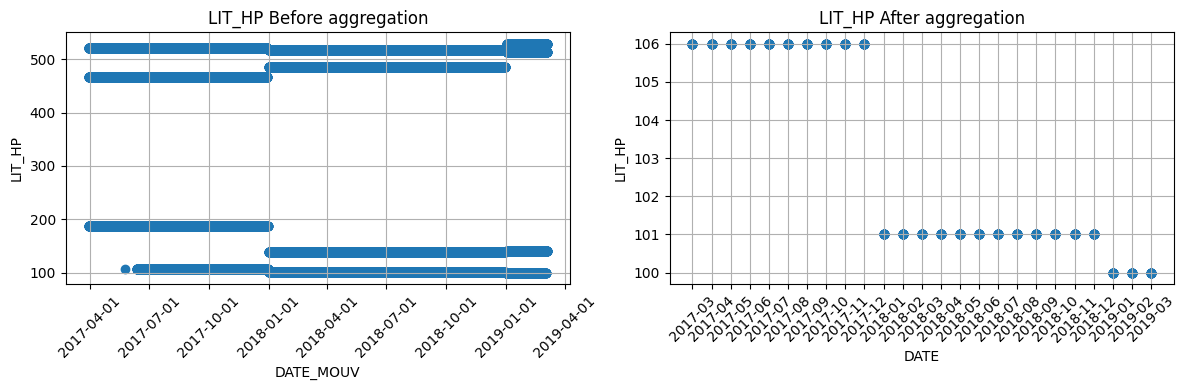

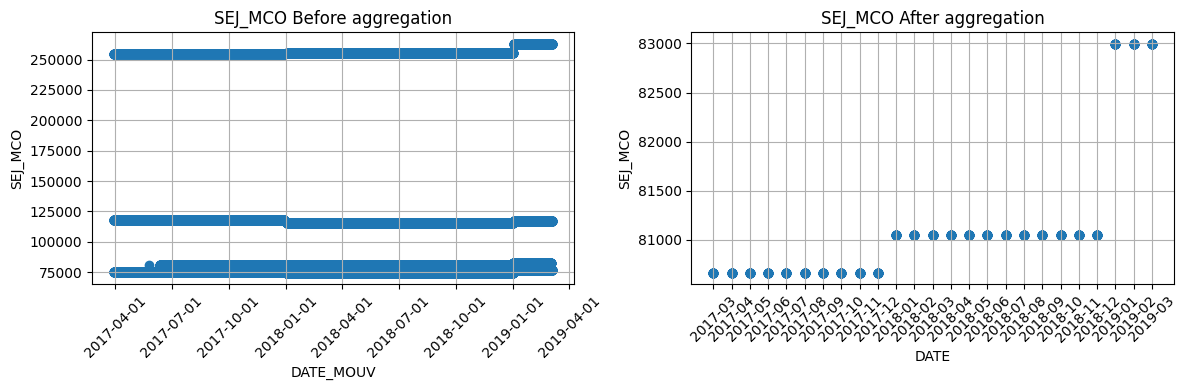

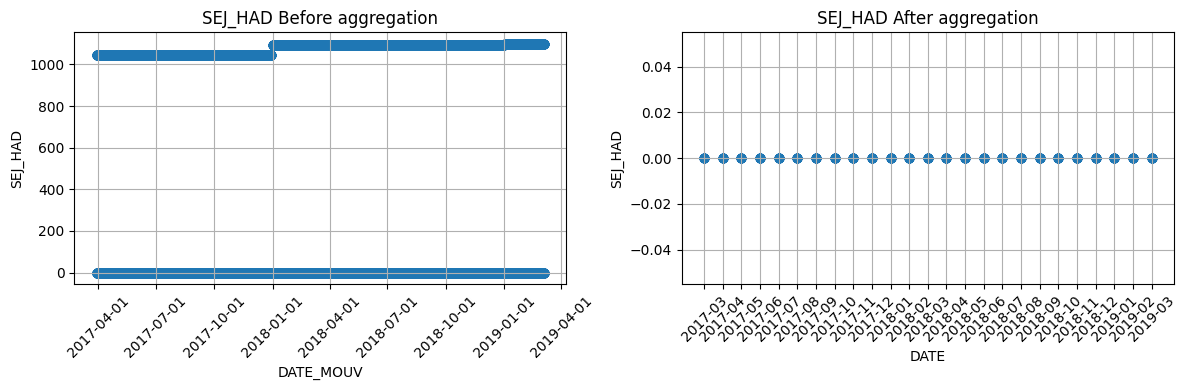

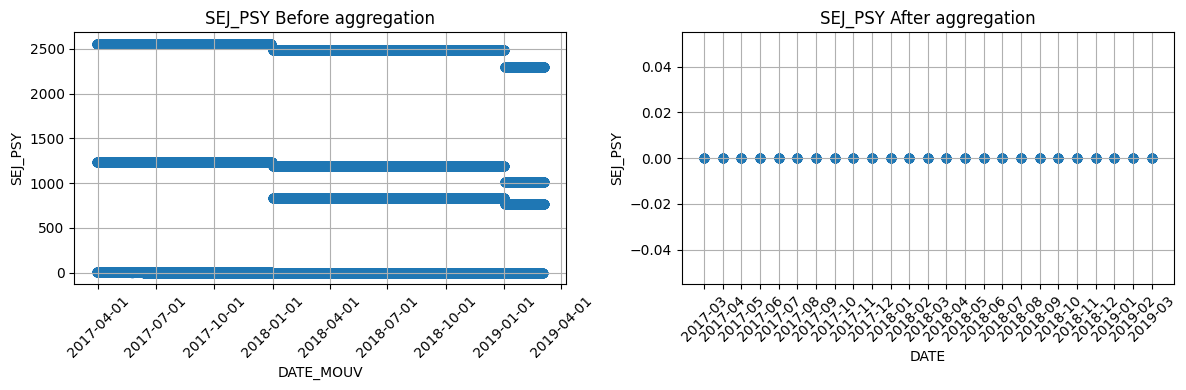

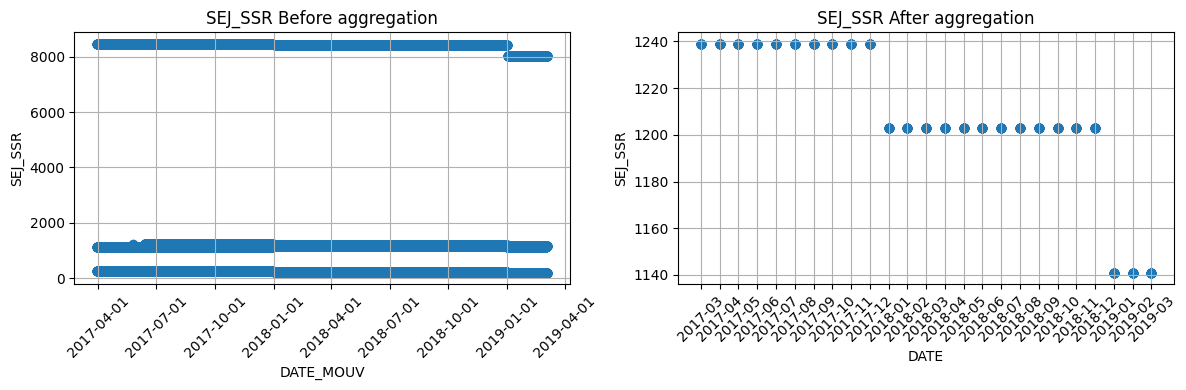

In [69]:
for column in numerical_features:
  plot_columns_bfaf(df_wo_outliers, df_resampled, column, date_before = 'DATE_MOUV', date_after = 'DATE')

## 2.7 - Transform categorical features

In [71]:
df_resampled_numerical_only = df_resampled.drop(['DATE'], axis=1).copy()


df_resampled_numerical_only["HOSPI_CODE_UCD"] = df_resampled_numerical_only["HOSPI_CODE_UCD"].astype(int)

codes = df_resampled_numerical_only["CODE_ATC"].unique()

# Create a dictionary to map unique codes to unique numbers
code_mapping = {code: i + 1 for i, code in enumerate(codes)}

# Map the codes to numbers using the dictionary
df_resampled_numerical_only["CODE_ATC"] = df_resampled_numerical_only["CODE_ATC"].map(code_mapping)

df_resampled_numerical_only["CODE_ATC"] = df_resampled_numerical_only["CODE_ATC"].astype(int)
df_resampled_numerical_only["WEEK"] = df_resampled_numerical_only["WEEK"].astype(int)

In [73]:
df_resampled_numerical_only.to_csv('df_resampled.csv', index=False)